In [15]:
import os
import numpy as np
import librosa
import soundfile as sf
from scipy.io.wavfile import write
import random

In [2]:
path = os.getcwd() + '/data/'
print("Création de la base de données")
sampleRate = 8000
# Import audio clean
# Train
pathTrain = path + 'train/target/'
dirTrain = os.listdir(pathTrain)
sonTrain = []
for fileAudio in dirTrain:
    son,_ = librosa.load(pathTrain + fileAudio, sr=sampleRate)
    sonTrain.append(son)
# Test
pathTest = path + 'test/target/'
dirTest = os.listdir(pathTest)
sonTest = []
for fileAudio in dirTest:
    son,_ = librosa.load(pathTest + fileAudio, sr=sampleRate)
    sonTest.append(son)
sonClean = sonTrain + sonTest
# Import le bruit
bruit, sr = librosa.load(path + '/babble.wav', sr=sampleRate)

Création de la base de données
Bruit importé


In [12]:
# Bruitage
puissance = lambda x :  1 / len(x) * np.sum([i**2 for i in x])
RSB = 0
sonBruite = []
for son in sonClean:
    # Découpe du bruit
    longueurSon = len(son)
    instantRandom = random.randint(0, len(bruit) - longueurSon-1)
    b =  bruit[instantRandom:instantRandom+longueurSon]
    # Appliquer le RSP
    puissanceB = puissance(b)
    puissanceSon = puissance(son)
    puissanceBPrime = puissanceSon / (np.power(10, RSB / 20) )
    b = np.sqrt(puissanceBPrime / puissanceB) * b
    print("Puissance b :{}, Puissance son : {}".format(puissance(b), puissanceSon))
    # Bruitage
    sonBruite.append(son + b)

 : 0.00018163141597685636
Puissance b :0.0003682236904004177, Puissance son : 0.00036822372504785345
Puissance b :8.655715135829774e-05, Puissance son : 8.655715279727421e-05
Puissance b :0.00017023822623134094, Puissance son : 0.00017023821507148717
Puissance b :0.00011366269038791305, Puissance son : 0.00011366269175873021
Puissance b :0.00046280227279815294, Puissance son : 0.00046280223411263526
Puissance b :7.101676884030334e-05, Puissance son : 7.101676197602851e-05
Puissance b :0.00012569257385240977, Puissance son : 0.00012569257343222906
Puissance b :0.00013300920805113485, Puissance son : 0.00013300921080488197
Puissance b :0.0009318806628884411, Puissance son : 0.0009318806920922418
Puissance b :0.00013023072546342222, Puissance son : 0.00013023073358998463
Puissance b :0.00021093706808507397, Puissance son : 0.0002109370814148311
Puissance b :0.000643354618711693, Puissance son : 0.000643354579912209
Puissance b :9.070523060274325e-05, Puissance son : 9.070522330373617e-05


In [17]:
# Séparation des sons
sonBruiteTrain = sonBruite[:len(sonTrain)]
sonBruiteTest = sonBruite[len(sonTrain):]
pathPTrain = path + '/train/predictor/'
pathPTest = path + '/test/predictor/'
for i,nameFile in enumerate(dirTrain):
    write(pathPTrain + nameFile, sampleRate, sonBruiteTrain[i])
for i,nameFile in enumerate(dirTest):
    write(pathPTest + nameFile, sampleRate, sonBruiteTest[i])

In [1]:
import os
import soundfile as sf
def load_database():
    """
    Charge la base de données.

    Returns values :
    -------------------------------------------------
    x_train : predicteur d'entrainement
    x_test : predicteur de test
    y_train : cible d'entrainement
    y_test : cible de test
    """
    path = os.getcwd() + '/data/'
    x_train, x_test, y_train, y_test = [],[],[],[]
    pathTrainP = path + '/train/predictor/'
    pathTrainT = path + '/train/target/'
    pathTestP = path + '/test/predictor/'
    pathTestT = path + '/test/target/'

    for dirFile in os.listdir(pathTrainP):
        son,_ = sf.read(pathTrainP + dirFile)
        x_train.append(son)
    for dirFile in os.listdir(pathTestP):
        son,_ = sf.read(pathTestP + dirFile)
        x_test.append(son)
    for dirFile in os.listdir(pathTrainT):
        son,_ = sf.read(pathTrainT + dirFile)
        y_train.append(son)
    for dirFile in os.listdir(pathTestT):
        son,_ = sf.read(pathTestT + dirFile)
        y_test.append(son)
    return x_train, x_test, y_train, y_test
a, b,c ,d = load_database()

In [7]:
# Import
from load_database import *
from FeatureExtractor import *
import numpy as np
import matplotlib.pyplot as plt
from librosa import display 

In [8]:

# Load data
x_train, x_test, y_train, y_test, sampleRate = load_database()


In [9]:
# Feature extraction parameters
sampleRate = 8000 # Voir create_database
dureeFenetre = 3e-2 # en s
windowLength = np.power(2,round(np.log2(dureeFenetre * sampleRate)))
overlap      = round((1 - .75) * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = sampleRate
fs           = inputFs
numFeatures  = ffTLength//2 + 1
numSegmentsInput  = round(windowLength / overlap)
numSegmentsOutput = 1
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegmentsInput:",numSegmentsInput)
print("numSegmentsOutput:",numSegmentsOutput)

# Feature 
extractor = FeatureExtractor(x_train[0], windowLength=windowLength, overlap=overlap,            sample_rate=sampleRate)
stft = extractor.get_stft_spectrogram()

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 8000
fs: 8000
numFeatures: 129
numSegmentsInput: 4
numSegmentsOutput: 1


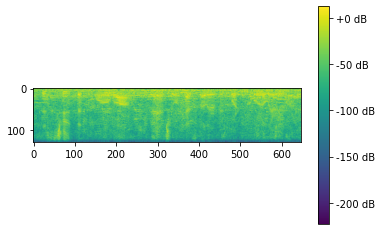

In [4]:
stft_magn = np.abs(stft)**2
stft_db = 20 * np.log10(stft_magn)
plt.figure("Je fais un test")
stft_db_im = plt.imshow(stft_db)
plt.colorbar(stft_db_im, format="%+2.f dB")
plt.show()

In [10]:
train_x, test_x, train_y, test_y = [], [], [], []
for i,data in enumerate(x_train):
    extractor = FeatureExtractor(data, windowLength=windowLength, 
    overlap=overlap, sample_rate=sampleRate)
    stft = extractor.get_stft_spectrogram()
    magn, phase = extractor.get_magn_phase_from_stft(stft)

    for i in range(0, magn.shape[1], numSegmentsInput):
        train_x.append(magn[:,i:i+numSegmentsInput])
print("Taille train_x : {}".format(len(train_x)))
print("Taille élément train_x : {}".format(train_x[0].shape))



KeyboardInterrupt: 

In [ ]:
from fonctions_divers import decoupage
train_x = decoupage(x_train, numSegmentsInput=numSegmentsInput, windowLength=windowLength,
                    overlap=overlap, sample_rate=sampleRate)
print(len(train_x))
print(train_x[0].shape)